In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sb
import matplotlib.pyplot as plt

In [7]:
# Load data
df = pd.read_csv('../data/creditcard.csv')

# Check for missing values
if df.isnull().values.any():
    df = df.dropna()  # Drop rows with any missing values if any

# Drop irrelevant feature
df.drop('Time', axis=1, inplace=True)

# Scale the 'Amount' column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

In [8]:
# Separate features and labels
X = df.drop('Class', axis=1)
y = df['Class']

# Filter the data to have only normal transactions for training
normal_data = df[df['Class'] == 0]
fraud_data = df[df['Class'] == 1]


In [9]:
# Split the normal data into training and test sets
X_train, X_test_normal, _, y_test_normal = train_test_split(
    normal_data.drop('Class', axis=1), normal_data['Class'], test_size=0.2, random_state=42)

# Include all fraud transactions and a portion of normal transactions in the test set
X_test = pd.concat([X_test_normal, fraud_data.drop('Class', axis=1)])
y_test = pd.concat([y_test_normal, fraud_data['Class']])

In [10]:
# Normalize the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Define datasets
train_data = TensorDataset(X_train_tensor, X_train_tensor)
test_data = TensorDataset(X_test_tensor, X_test_tensor)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [11]:
# Define the AutoEncoder model
class AutoEncoder(nn.Module):
    def __init__(self, sparsity_target, sparsity_weight):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(X.shape[1], 14),
            nn.LeakyReLU(),
            nn.Linear(14, 7),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(7, 14),
            nn.LeakyReLU(),
            nn.Linear(14, X.shape[1]),
            nn.Sigmoid()
        )
        self.sparsity_target = sparsity_target
        self.sparsity_weight = sparsity_weight

    def forward(self, x):
        encoded = self.encoder(x)
        self.data_rho = encoded.mean(0)
        decoded = self.decoder(encoded)
        return decoded
    
    def kl_divergence(self, rho_hat):
        rho = self.sparsity_target
        return rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))

    def loss_function(self, output, target, rho_hat):
        reconstruction_loss = torch.nn.functional.mse_loss(output, target, reduction='mean')
        sparsity_loss = self.sparsity_weight * torch.sum(self.kl_divergence(rho_hat))
        return reconstruction_loss + sparsity_loss
    
# Initialize the model, loss function, and optimizer
sparsity_target = 0.5
sparsity_waight = 0.5
model = AutoEncoder(sparsity_target=sparsity_target, sparsity_weight=sparsity_waight)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Training the model
def train_model(model, dataloader):
    model.train()
    total_loss = 0
    for data, target in dataloader:
        optimizer.zero_grad()
        output = model(data)
        rho_hat = torch.mean(model.encoder(data), dim=0)
        loss = model.loss_function(output, target, rho_hat)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [13]:
# Train the AutoEncoder
epoch_losses = []
epochs = 50
for epoch in range(epochs):
    loss = train_model(model, train_loader)
    epoch_losses.append(loss)
    print(f'Epoch {epoch+1}, Loss: {loss}')

Epoch 1, Loss: nan
Epoch 2, Loss: 0.8795459111570708
Epoch 3, Loss: 0.8472721674382586
Epoch 4, Loss: 0.8268329384760301
Epoch 5, Loss: 0.8199262020456436
Epoch 6, Loss: 0.8165978227328503
Epoch 7, Loss: 0.8142247587928761
Epoch 8, Loss: 0.8115518853890138
Epoch 9, Loss: 0.8097474838894743
Epoch 10, Loss: 0.808046072549577
Epoch 11, Loss: 0.8067569172845238
Epoch 12, Loss: 0.8056581541183093
Epoch 13, Loss: 0.8048668725224244
Epoch 14, Loss: 0.8040276722260319
Epoch 15, Loss: 0.8031078102753682
Epoch 16, Loss: 0.8019487328437452
Epoch 17, Loss: 0.8009455622282334
Epoch 18, Loss: 0.8003453801422221
Epoch 19, Loss: 0.7997337900349513
Epoch 20, Loss: 0.7993230257239916
Epoch 21, Loss: 0.7989302164359783
Epoch 22, Loss: 0.7984570029097859
Epoch 23, Loss: 0.7982747327110776
Epoch 24, Loss: 0.7979731268438651
Epoch 25, Loss: 0.7978980001827338
Epoch 26, Loss: 0.7975775301540308
Epoch 27, Loss: 0.7975724340659148
Epoch 28, Loss: 0.7971279411359188
Epoch 29, Loss: 0.7970858189326092
Epoch 30, 

In [14]:
# Modify the evaluation function to return actual loss values per instance
def evaluate_model(model, dataloader, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for data, _ in dataloader:
            output = model(data)
            loss = criterion(output, data)
            losses.extend(loss.item() for _ in range(data.size(0)))
    return losses

In [15]:
# Evaluate model to get losses for each instance in the train set
train_loss = evaluate_model(model, train_loader, criterion)
average_train_loss = np.mean(train_loss)
print(f'Average Training Reconstruction Loss: {average_train_loss}')

# Evaluate model to get losses for each instance in the test set
test_losses = evaluate_model(model, test_loader, criterion)
average_test_loss = np.mean(test_losses)
print(f'Average Test Reconstruction Loss: {average_test_loss}')

# Determine the threshold for anomaly detection (setting at the 95th percentile of test losses)
threshold = np.quantile(test_losses, 0.95)
print(f'Anomaly Detection Threshold: {threshold}')

Average Training Reconstruction Loss: 0.7923528114750578
Average Test Reconstruction Loss: 1.0130028815789498
Anomaly Detection Threshold: 1.5055391788482666


Accuracy: 0.9586958416877343, 
Precision: 0.17173837005946135, 
Recall: 0.9979674796747967, 
F1 Score: 0.29304685168606387


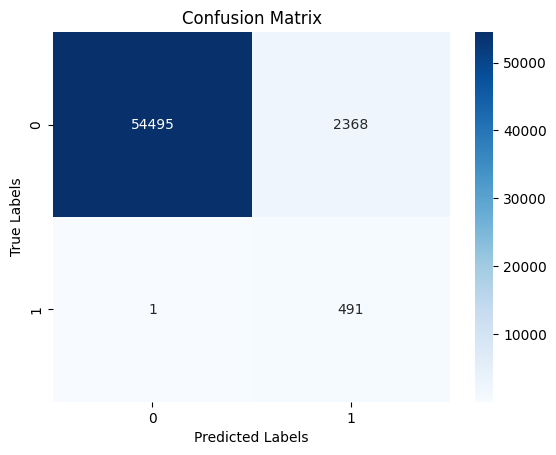

In [16]:
# Generate binary predictions based on the threshold
predicted_anomalies = np.array([1 if loss > threshold else 0 for loss in test_losses])
actual_anomalies = y_test.to_numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(actual_anomalies, predicted_anomalies)
precision = precision_score(actual_anomalies, predicted_anomalies)
recall = recall_score(actual_anomalies, predicted_anomalies)
f1 = f1_score(actual_anomalies, predicted_anomalies)

print(f'Accuracy: {accuracy}, \nPrecision: {precision}, \nRecall: {recall}, \nF1 Score: {f1}')

# Plotting the confusion matrix
conf_matrix = confusion_matrix(actual_anomalies, predicted_anomalies)
sb.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [82]:
# # Save the model's state dictionary
# torch.save(model.state_dict(), 'autoencoder_model_weights2.pth')


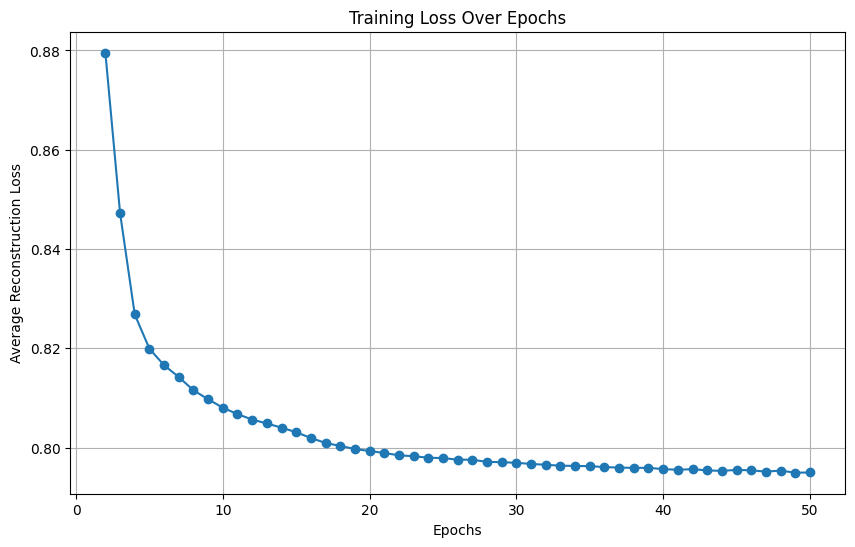

ValueError: too many values to unpack (expected 2)

In [17]:
# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), epoch_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Reconstruction Loss')
plt.grid(True)
plt.show()

# After training, evaluate the model to get reconstruction losses and labels
reconstruction_losses, labels = evaluate_model(model, test_loader, criterion)